In [89]:
from selenium import webdriver
from selenium.webdriver.edge.service import Service
from selenium.webdriver.edge.options import Options
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import pandas as pd
from datetime import datetime
import time

driver_path = 'C:/edgedriver/msedgedriver.exe'
service = Service(driver_path)
options = Options()

options.add_argument('--disable-gpu')

max_retries = 3
retry_count = 0

def load_page():
    global retry_count
    while retry_count < max_retries:
        try:
            driver = webdriver.Edge(service=service, options=options)
            print("Navigating to the URL...")
            driver.get(url)
            # Wait for the specific table to load
            table_xpath = "//table[contains(@class, 'tables')]"
            WebDriverWait(driver, 60).until(
                EC.presence_of_element_located((By.XPATH, table_xpath))
            )
            print("Page loaded.")
            return driver
        except Exception as e:
            retry_count += 1
            print(f"Retrying ({retry_count}/{max_retries}) due to error: {e}")
            driver.quit()
            time.sleep(5)
    raise Exception("Failed to load the page after multiple attempts.")

url = 'https://www.bseindia.com/markets/PublicIssues/IPOIssues_new.aspx?id=2&Type=P'

try:
    driver = load_page()

    
    time.sleep(10) 

    
    table = driver.find_element(By.XPATH, "//table[contains(@class, 'tables')]")
    rows = table.find_elements(By.TAG_NAME, 'tr')

    
    headers = []
    for row in rows:
        headers = [header.text.strip() for header in row.find_elements(By.TAG_NAME, 'th')]
        if headers:
            print("Headers extracted:", headers)
            break

    if not headers:
        headers = [header.text.strip() for header in rows[0].find_elements(By.TAG_NAME, 'td')]
        print("Headers extracted:", headers)

    
    print("Headers content:", headers)

    
    data = []
    for row in rows[1:]:  
        cells = row.find_elements(By.TAG_NAME, 'td')
        if len(cells) > 1:
            data.append([cell.text.strip() for cell in cells])

    print(f"Extracted {len(data)} rows.")

    
    for row in data:
        print(row)

    
    df = pd.DataFrame(data, columns=headers)

    
    if "Start Date" in df.columns:
        df["Start Date"] = pd.to_datetime(df["Start Date"], format='%d-%m-%Y', errors='coerce')
        start_date = datetime(2024, 1, 1)
        end_date = datetime(2024, 12, 31)
        filtered_df = df[(df["Start Date"] >= start_date) & (df["Start Date"] <= end_date)]

        if not filtered_df.empty:
            filtered_df.to_csv('ipo_issues_2024_filtered.csv', index=False)
            print("Filtered data saved to 'ipo_issues_2024_filtered.csv'.")
        else:
            print("No IPOs found within the specified date range.")
    else:
        print("Error: 'Start Date' column not found in data.")

except Exception as e:
    print("An error occurred:", e)

finally:
    try:
        driver.quit()
        print("Web driver closed.")
    except:
        pass


Navigating to the URL...
Page loaded.
Headers extracted: ['Security Name', 'Start Date', 'End Date', 'Offer Price ()', 'Face Value', 'Type of Issue']
Headers content: ['Security Name', 'Start Date', 'End Date', 'Offer Price ()', 'Face Value', 'Type of Issue']
Extracted 497 rows.
['Nido Home Finance Limited (formerly known as Edelweiss Housing Finance Limited)', '17-12-2024', '31-12-2024', '', '', 'DPI']
['CITICHEM INDIA LIMITED', '27-12-2024', '31-12-2024', '70.00', '10.00', 'FPO']
['ENBEE TRADE FINANCE LTD', '10-12-2024', '30-12-2024', '13.00', '10.00', 'RI']
['ACE SOFTWARE EXPORTS LTD', '16-12-2024', '27-12-2024', '78.00', '10.00', 'RI']
['KOTHARI INDUSTRIAL CORPORATION LTD', '13-12-2024', '27-12-2024', '14.33', '5.00', 'OTB']
['MOONGIPA CAPITAL FINANCE LTD', '12-12-2024', '27-12-2024', '25.00', '10.00', 'RI']
['ASTEC LIFESCIENCES LIMITED', '12-12-2024', '26-12-2024', '1094.96', '10.00', 'OTB']
['Unimech Aerospace and Manufacturing Limited', '23-12-2024', '26-12-2024', '745.00 - 785.

In [93]:
if not df.empty:
    print("\nStarting data wrangling...")

    df.columns = [col.strip().replace(" ", "_").lower() for col in df.columns]
    print("\nStandardized column names:", df.columns)

    print("\nMissing values per column:")
    print(df.isnull().sum())

    df = df.dropna(how='all')
    
    if 'start_date' in df.columns:
        df['start_date'] = pd.to_datetime(df['start_date'], format='%d-%m-%Y', errors='coerce')
        print("\nParsed 'start_date' to datetime format.")

        df = df[df['start_date'].notnull()]

    initial_rows = len(df)
    df = df.drop_duplicates()
    print(f"\nRemoved {initial_rows - len(df)} duplicate rows.")

    if 'start_date' in df.columns:
        start_date = datetime(2024, 1, 1)
        end_date = datetime(2024, 12, 31)
        df = df[(df['start_date'] >= start_date) & (df['start_date'] <= end_date)]
        print(f"\nFiltered data for IPOs between {start_date} and {end_date}.")

    if 'price' in df.columns:
        df['price'] = df['price'].replace('[^0-9.]', '', regex=True).astype(float)
        print("\nConverted 'price' column to numeric.")

    cleaned_file = 'ipo_issues_cleaned.csv'
    df.to_csv(cleaned_file, index=False)
    print(f"\nCleaned data saved to '{cleaned_file}'.")
else:
    print("\nNo data extracted for wrangling.")



Starting data wrangling...

Standardized column names: Index(['security_name', 'start_date', 'end_date', 'offer_price_()',
       'face_value', 'type_of_issue'],
      dtype='object')

Missing values per column:
security_name     0
start_date        0
end_date          0
offer_price_()    0
face_value        0
type_of_issue     0
dtype: int64

Parsed 'start_date' to datetime format.

Removed 0 duplicate rows.

Filtered data for IPOs between 2024-01-01 00:00:00 and 2024-12-31 00:00:00.

Cleaned data saved to 'ipo_issues_cleaned.csv'.


In [136]:
df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')
df['offer_price_()'] = pd.to_numeric(df['offer_price_()'], errors='coerce')

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
file_path = 'ipo_issues_cleaned.csv'
df = pd.read_csv(file_path)

In [9]:
df

,security_name,start_date,end_date,offer_price_(),face_value,type_of_issue
0,Nido Home Finance Limited (formerly known as E...,2024-12-17,31-12-2024,NaN,NaN,DPI
1,CITICHEM INDIA LIMITED,2024-12-27,31-12-2024,70.00,10.0,FPO
2,ENBEE TRADE FINANCE LTD,2024-12-10,30-12-2024,13.00,10.0,RI
3,ACE SOFTWARE EXPORTS LTD,2024-12-16,27-12-2024,78.00,10.0,RI
4,KOTHARI INDUSTRIAL CORPORATION LTD,2024-12-13,27-12-2024,14.33,5.0,OTB
...,...,...,...,...,...,...
492,SHREE MARUTINANDAN TUBES LIMITED,2024-01-12,16-01-2024,143.00,10.0,FPO
493,360 ONE Prime Limited - Tranche I,2024-01-11,15-01-2024,NaN,NaN,DPI
494,NEW SWAN MULTITECH LIMITED,2024-01-11,15-01-2024,62.00 - 66.00,10.0,IPO
495,Kosamattam Finance Ltd,2024-01-01,12-01-2024,NaN,NaN,DPI


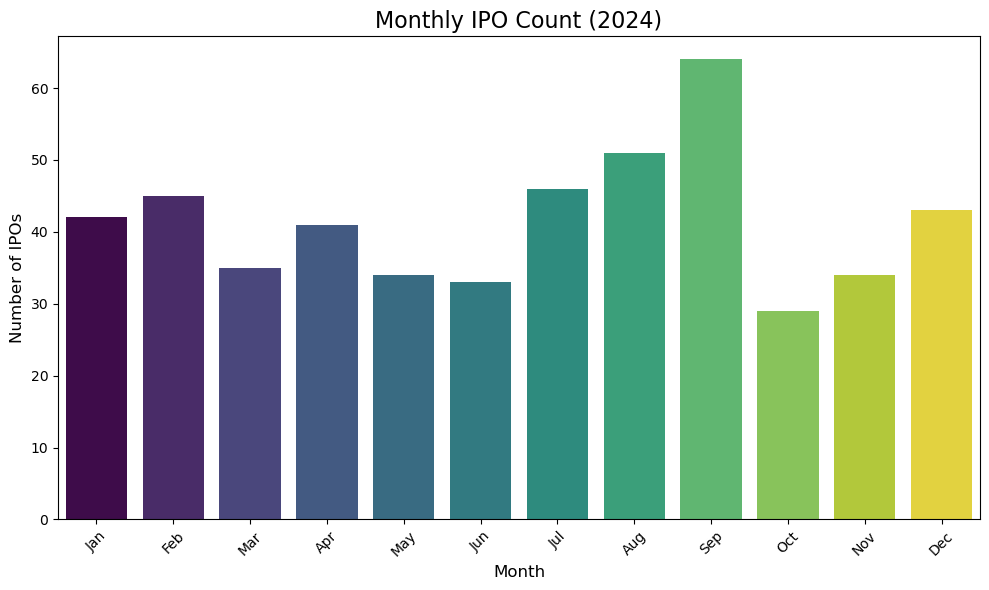

In [126]:
# 1. IPO Count by Month
df['month'] = df['start_date'].dt.month
ipo_counts = df.groupby('month').size()
plt.figure(figsize=(10, 6))
sns.barplot(x=ipo_counts.index, y=ipo_counts.values, hue=ipo_counts.index, palette="viridis", legend=False)
plt.title('Monthly IPO Count (2024)', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of IPOs', fontsize=12)
plt.xticks(range(12), ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                       'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.tight_layout()
plt.savefig('monthly_ipo_count.png')
plt.show()


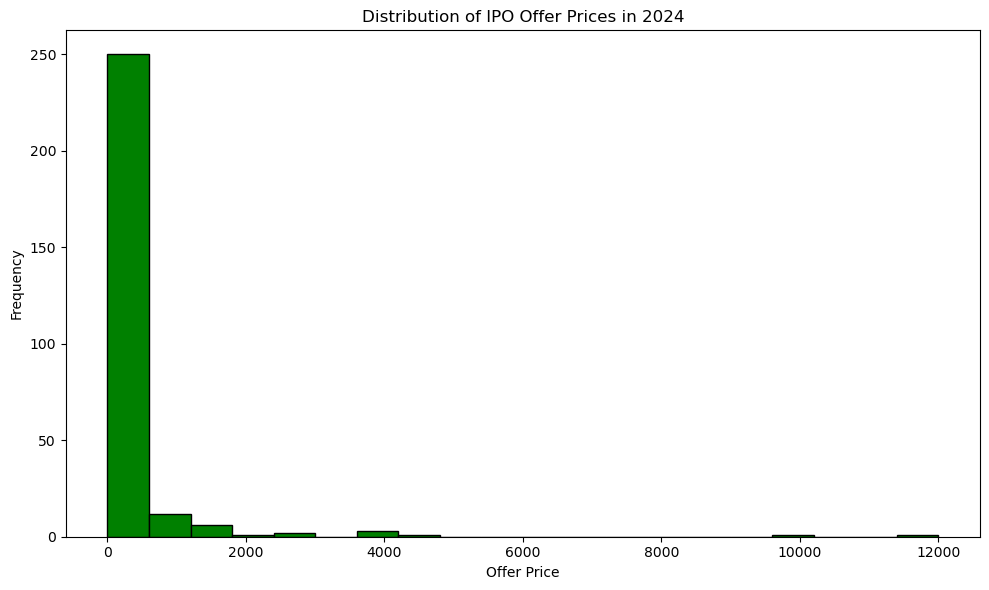

In [128]:
# 2 IPO Offer Price Distribution
plt.figure(figsize=(10,6))
df['offer_price_()'].plot(kind='hist', bins=20, color='green', edgecolor='black')
plt.title('Distribution of IPO Offer Prices in 2024')
plt.xlabel('Offer Price')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

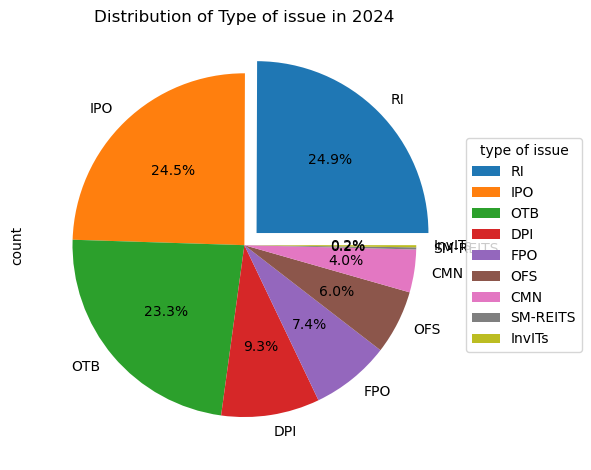

In [130]:
# 3 distribution of ipo type in 2024
ipo_type_count = df['type_of_issue'].value_counts()
explode = [0.1 if i == ipo_type_count.idxmax() else 0 for i in ipo_type_count.index] 
plot = ipo_type_count.plot(kind='pie', title='Distribution of Type of issue in 2024', autopct='%1.1f%%', labels=ipo_type_count.index, explode=explode)
plt.legend(labels=ipo_type_count.index, title='type of issue', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()
plt.show()

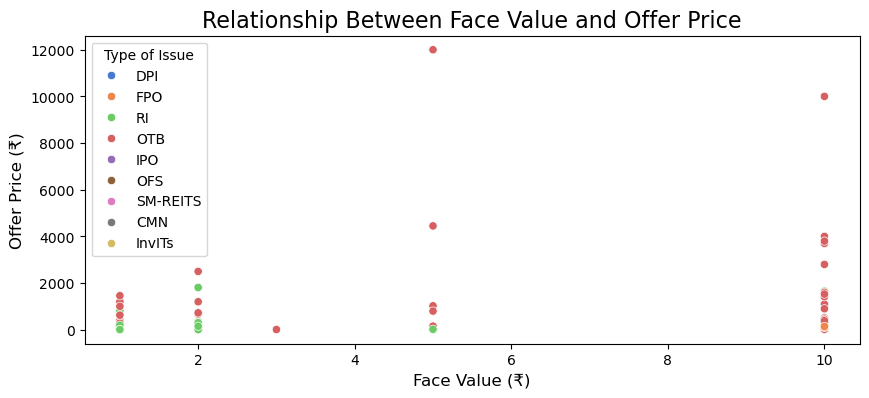

In [134]:
# 4. Correlation Between Offer Price and Face Value
plt.figure(figsize=(10,4))
sns.scatterplot(data=df, x='face_value', y='offer_price_()', hue='type_of_issue', palette="muted")
plt.title("Relationship Between Face Value and Offer Price", fontsize=16)
plt.xlabel("Face Value (₹)", fontsize=12)
plt.ylabel("Offer Price (₹)", fontsize=12)
plt.legend(title="Type of Issue")
plt.show()

<Axes: title={'center': 'Average Offer Price vs Face Value per Month'}, xlabel='month'>

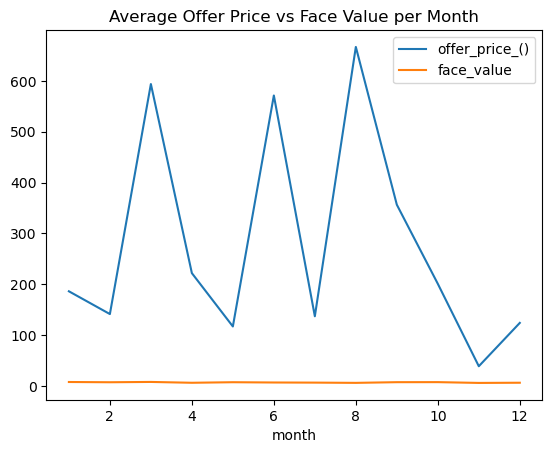

In [120]:
# 5 offer price vs face values

monthly_averages = df.groupby('month')[['offer_price_()', 'face_value']].mean()
monthly_averages.plot(kind='line', title='Average Offer Price vs Face Value per Month')


In [83]:
# 6. Top IPOs by Offer Price
top_offers = df.nlargest(10, 'offer_price_()')
print("\nTop 10 IPOs by Offer Price:")
print(top_offers[['security_name', 'offer_price_()', 'type_of_issue']])


Top 10 IPOs by Offer Price:
                               security_name  offer_price_() type_of_issue
191                    CERA SANITARYWARE LTD         12000.0           OTB
403                           BAJAJ AUTO LTD         10000.0           OTB
295                   ANAND RATHI WEALTH LTD          4450.0           OTB
151  ANGLO FRENCH DRUGS & INDUSTRIES LIMITED          4000.0           OTB
378             GARWARE TECHNICAL FIBRES LTD          3800.0           OTB
167                                 KDDL LTD          3700.0           OTB
259                      ECLERX SERVICES LTD          2800.0           OTB
182                         SYMPHONY LIMITED          2500.0           OTB
475                    GRASIM INDUSTRIES LTD          1812.0            RI
292              SHARDA MOTOR INDUSTRIES LTD          1800.0           OTB
